# Quenched Fractions

This notebook contains all of the quenched fraction plots. 

In [1]:
# first we import all relevant packages
from bulk import * # bulk.py stores a lot of my personal functions, i.e. for reading from the .data files and such
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pynbody
from scipy import stats
from scipy.stats import binned_statistic


In [2]:
# we set the global matplotlib parameters so the fonts are all consistent and serif 
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

In [3]:
# wilson score interval is used to calculate error in fractional quantities
def WilsonScoreInterval(z,p,M):
    return (1/(1+(z**2)/M)) * (p + ((z**2)/(2*M)) + z * np.sqrt((p*(1-p)/M) + (z**2)/(4*M**2)))

# quenched definition
def quenched(data):
    return np.array(data.sSFR < 1e-11, dtype=bool)

## Quenched Fraction vs Distance to Host

Here we plot the fraction of quenched galaxies vs distance to the nearest massive galaxy (with $M_{\mathrm{vir}} > 10^{11.5}~\mathrm{M}_{\odot}$). The distance to nearest host definition is specified in `bulk.py`. Bins of distance are selected such that there are an equal number of galaxies in each bin. We limit the data to halos with more than 10 star particles, and error bars show binomial error computed via the Wilson Score Interval.

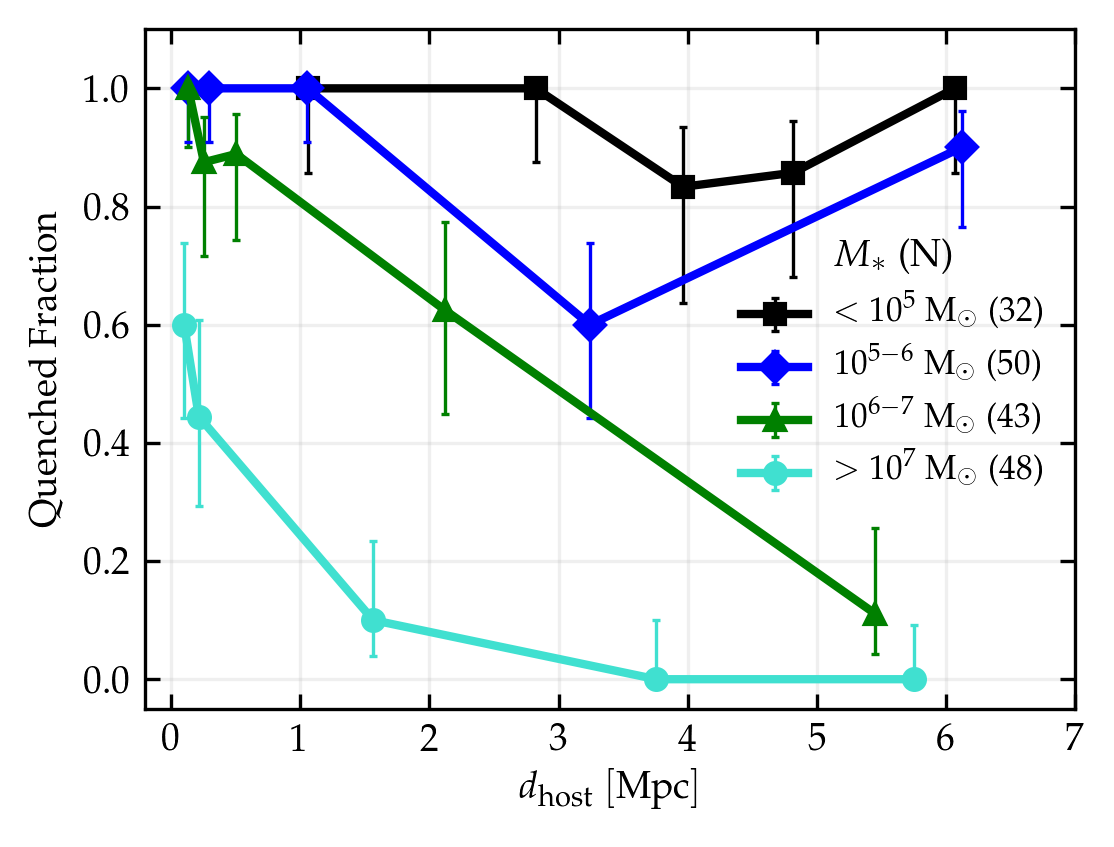

In [22]:
fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=300)

# read in the data and limit to > 10 star particles
data = read_all()
data = data[data.n_star > 10]

# load in the distances to nearest host galaxies
dist, vir = distance_to_nearest_host(data)

# clean up the data (remove dist==0 since we don't want to consider the massive halo 1's)
q = quenched(data)[dist!=0]
mass = np.log10(np.array(data['M_star'],dtype=float))[dist!=0]
haloid = np.array(data['haloid'])[dist!=0]
sim = np.array(data['sim'])[dist!=0]
dist = dist[dist!=0]


# set up important plotting stuff
nbins = 5
colors = ['k','b', 'g', '#40E0D0']
markers = ['s','D','^','o']


# set up the mass bins
bin0 = mass < 5
bin1 = (mass > 5) & (mass < 6)
bin2 = (mass > 6) & (mass < 7)
bin3 = mass > 7
labels = [r'$< 10^5~\mathrm{M}_{\odot}$',r'$10^{5-6}\ \mathrm{M}_{\odot}$', r'$10^{6-7}\ \mathrm{M}_{\odot}$',r'$> 10^{7}\ \mathrm{M}_{\odot}$']

# now loop through the bins and plot the relevant data
for i, (b, label) in enumerate(zip([bin0,bin1,bin2,bin3],labels)):
    di = dist[b] # distances specific to this subset of the data
    qu = q[b] # boolean quenched values specific to this subset of the data
    
    # calculate bin edges based on quantiles
    quantiles = np.linspace(0.0,1.0,nbins+1)
    bin_edges = stats.mstats.mquantiles(di, quantiles) 
    
    y2, binEdges2 = np.histogram(di,bins=bin_edges)
    y1, binEdges1 = np.histogram(di[qu],bins=bin_edges)
    bincenters1 = 0.5*(binEdges1[1:]+binEdges1[:-1])
    name = label +' (%s)' % len(di)

    p = y1/y2
    M = y2
    
    ax.errorbar(bincenters1/1000,y1/y2,
                yerr=np.array([p - WilsonScoreInterval(-1,p,M), WilsonScoreInterval(1,p,M) - p]),
                ecolor=colors[i],
                elinewidth=0.8, 
                capsize=1,
                capthick=0.8,
                fmt = 'o-',
                ms = 5,
                marker=markers[i],
                c=colors[i],
                linewidth=2,label=name)

    
# labels and limits
ax.set_xlabel(r'$d_{\mathrm{host}}\ [\mathrm{Mpc}]$')
ax.set_ylabel(r'Quenched Fraction')
ax.set_ylim(-0.05,1.1)
ax.set_xlim(-0.2, 7)

# legend 
leg = ax.legend(prop={'size':8},frameon=False,loc='best', title=r'$M_*$ (N)')

# ticks
ax.grid(alpha=0.2)
ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

# save and show
# fig.savefig('QF_distance.png', dpi=300)
plt.show()

## Observational data from McConnachie

In [5]:
# load in the McConnachie2012Data.csv file which I downloaded from SIMBAD
mcconnachie = pd.read_csv('McConnachie2012Data.csv')
MW = mcconnachie[(mcconnachie.SubG=='MW')&(mcconnachie.DMW < 300)] # select MW satellites

# define quenched the way that Wetzel (2015) did: mHI/Mstar < 0.1, or mHI is nan, since that means HI is undetected
q = np.array((MW.mHI / MW.Mstar < 0.2) | np.isnan(MW.mHI),dtype=bool)
bins = np.arange(3,11,1) # 1 dex bins
mstar = np.log10(MW.Mstar*1e6) 
y1, binEdges = np.histogram(mstar, bins=bins)
y2, binEdges = np.histogram(mstar[q], bins=bins)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
MW_Mc = y2/y1 
bc_Mc = bincenters # bincenters will be the same for all three
MW_N_Mc = y1

M31 = mcconnachie[(mcconnachie.SubG=='M31')&(mcconnachie.DM31 < 300)] # select M31 satellites
M31 = M31[M31.Name != "Triangulum"] # remove Triangulum since it doesn't have enough info
q = np.array((M31.mHI / M31.Mstar < 0.2) | np.isnan(M31.mHI),dtype=bool) # define quenched
mstar = np.log10(M31.Mstar*1e6)
y1, binEdges = np.histogram(mstar, bins=bins)
y2, binEdges = np.histogram(mstar[q], bins=bins)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
M31_Mc = y2/y1
M31_N_Mc = y1


# now we want the data for both, combined
All = MW.append(M31) 

q = np.array((All.mHI / All.Mstar < 0.2) | np.isnan(All.mHI),dtype=bool)
mstar = np.log10(All.Mstar*1e6)
y1, binEdges = np.histogram(mstar, bins=bins)
y2, binEdges = np.histogram(mstar[q], bins=bins)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
All_Mc = y2/y1
All_N_Mc = y1

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


## Quenched Fraction vs Stellar Mass

With observational comparisons. 

field QF > 1e7 0.0
field QF > 1e8 0.0


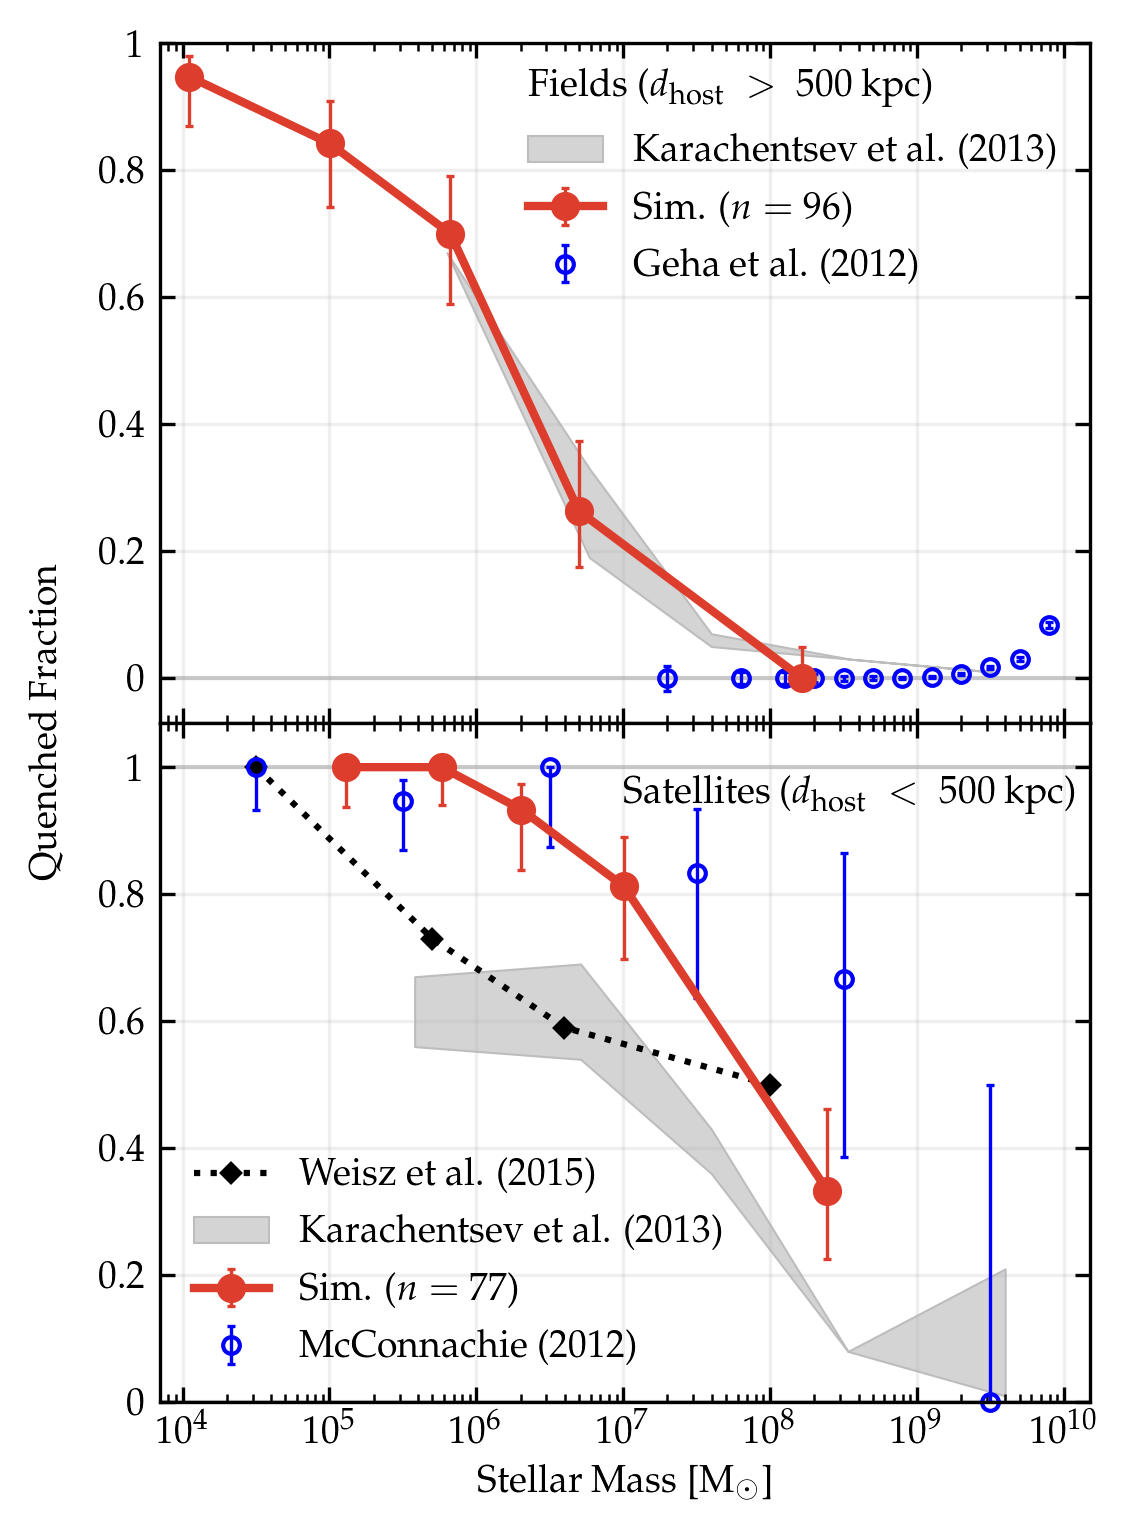

In [21]:
# load in the data and clean up 
data = read_all()
data = data[data['n_star']>10]

# load in distance to nearest host
dist, vir = distance_to_nearest_host(data)
s = dist < 500 # define satellites as those where dist < 500 kpc (to go on lower panel)
s = s[dist!=0]
mass = np.log10(np.array(data['M_star'],dtype=float))[dist!=0]
q = quenched(data)[dist!=0]
dist = dist[dist!=0]


# set up import plotting stuff
nbins = 5
colors = ['#DD3D2D', '#FDB366']
markers = ['D','o','^']
fig,ax = plt.subplots(2,1,figsize=(4,6),dpi=300,sharex=True)

# First, plot only field dwarfs (upper panel)
quantiles = np.linspace(0.0,1.0,nbins+1)
bin_edges = stats.mstats.mquantiles(mass[~s],quantiles)
y2, binEdges2 = np.histogram(mass[~s],bins=bin_edges)
y1, binEdges1 = np.histogram(mass[q & ~s], bins=bin_edges)
bincenters = 0.5*(binEdges1[1:]+binEdges1[:-1])
p = y1/y2
M = y2
ax[0].errorbar(10**bincenters,y1/y2,
               yerr = np.array([p - WilsonScoreInterval(-1, p, M), WilsonScoreInterval(1, p, M) - p]),
               fmt='o-',
               marker=markers[1],
               c=colors[0],
               label='Sim. ($n=\ $%s)' % len(mass[~s]),
               linewidth=2,
               zorder=20, 
               elinewidth=0.8, capsize=1,capthick=0.8)
   

print('field QF > 1e7',len(mass[~s&q&(mass>7)])/len(mass[~s&(mass>7)]))
print('field QF > 1e8',len(mass[~s&q&(mass>8)])/len(mass[~s&(mass>8)]))

# add Geha et al (2012) observational data (from table in paper)
bincenters = np.array([9.9,9.7,9.5,9.3,9.1,8.9,8.7,8.5,8.3,8.1,7.8,7.3])
y = np.array([0.084,0.031,0.017,0.007,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000])
yerr= np.array([0.0052,0.0032,0.0023,0.0016,0.0014,0.0019,0.0028,0.0043,0.0065,0.0091,0.0093,0.0193])

ax[0].errorbar(10**bincenters,y, yerr=yerr,marker='o',ms=4, linestyle='none', linewidth=2,ecolor='b',
               mec = 'b',mfc = 'none',elinewidth=0.8, capsize=1,capthick=0.8,clip_on=False,label='Geha et al. (2012)')


# add Karachentsev et al (2013) observational data compiled by Weisz (2014) (from table in paper)
bincenters = np.array([5.8,6.77,7.6,8.55,9.51])
y1 = np.array([0.67,0.19,0.05,0.03,0.01])
y2 = np.array([0.67,0.33,0.07,0.03,0.01])
ax[0].fill_between(10**bincenters, y1, y2, fc='#d4d4d4', ec='#bdbdbd', lw=0.5, label='Karachentsev et al. (2013)')


# add lines at 0 and 1    
ax[0].plot([1e3,1e12],[0,0],linestyle='-',color='k',linewidth=1,zorder=0,alpha=0.2)
ax[0].plot([1e3,1e12],[1,1],linestyle='-',color='k',linewidth=1,zorder=0,alpha=0.2)
    
# labels and limits
ax[0].set_ylim(-0.07,1)
ax[0].grid(alpha=0.2)

# legend and ticks
leg = ax[0].legend(prop={'size':9},frameon=False, loc = 'upper right', title=r'Fields ($d_{\mathrm{host}}\ >\ 500\ \mathrm{kpc}$)')
leg._legend_box.align = "left"
ax[0].semilogx()
ax[0].tick_params(direction='in',which='both')
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')
ax[0].set_yticklabels([None,0,0.2,0.4,0.6,0.8,1])


# Next, plot only satellites (bottom panel)
bin_edges = stats.mstats.mquantiles(mass[s],quantiles)
y2, binEdges2 = np.histogram(mass[s],bins=bin_edges)
y1, binEdges1 = np.histogram(mass[q & s], bins=bin_edges)
bincenters = 0.5*(binEdges1[1:]+binEdges1[:-1])

p = y1/y2
M = y2

ax[1].errorbar(10**bincenters,y1/y2,
               yerr = np.array([p - WilsonScoreInterval(-1, p, M), WilsonScoreInterval(1, p, M) - p]),
               fmt='o-',
               marker=markers[1],
               c=colors[0],
               label='Sim. ($n=\ $%s)' % len(mass[s]),
               linewidth=2,
               zorder=20, 
               elinewidth=0.8, capsize=1,capthick=0.8)


# add Karachentsev et al (2013) observational data compiled by Weisz (2015) (data from table)
bincenters = np.array([5.58,6.71,7.6,8.53,9.6])
y1 = np.array([0.56,0.54,0.36,0.08,0.21])
y2 = np.array([0.67,0.69,0.43,0.08,0.01])
ax[1].fill_between(10**bincenters, y1, y2, fc='#d4d4d4', ec='#bdbdbd', lw=0.5, label='Karachentsev et al. (2013)')

# add McConnachie (2012) data as seen in Wetzel (2015) observational data (data from previous cell)
yerr_lower = All_Mc - WilsonScoreInterval(-1,All_Mc,All_N_Mc)
yerr_upper = WilsonScoreInterval(1,All_Mc,All_N_Mc)-All_Mc
ax[1].errorbar(10**bc_Mc[1:],All_Mc[1:], 
               yerr=np.array([yerr_lower[1:], yerr_upper[1:]]),
               marker='o',ms=4, linestyle='none', linewidth=2,ecolor='b',mec = 'b',
               mfc = 'none',elinewidth=0.8, capsize=1,capthick=0.8,clip_on=False,label='McConnachie (2012)')

# add Weisz et al (2015) observational data (data from table)
bincenters = np.array([4.5,5.7,6.6,8.0])
y = np.array([1,0.73,0.59,0.5])
ax[1].plot(10**bincenters, y, 'D:', color='k', markersize=3, label='Weisz et al. (2015)')


ax[1].annotate(r'Satellites ($d_{\mathrm{host}}\ <\ 500\ \mathrm{kpc}$)', (1e7,0.93))

ax[1].plot([1e3,1e12],[0,0],linestyle='-',color='k',linewidth=1,zorder=0,alpha=0.2)
ax[1].plot([1e3,1e12],[1,1],linestyle='-',color='k',linewidth=1,zorder=0,alpha=0.2)
    
# labels and limits
ax[1].set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax[1].set_ylim(0.,1.07)
ax[1].set_xlim(7e3,1.5e10)
ax[1].grid(alpha=0.2)

# legend and ticks
ax[1].legend(prop={'size':9},frameon=False, loc='lower left')
ax[1].semilogx()
ax[1].tick_params(direction='in',which='both')
ax[1].yaxis.set_ticks_position('both')
ax[1].xaxis.set_ticks_position('both')
ax[1].set_yticklabels([0,0.2,0.4,0.6,0.8,1])

# add invisible axis the size of both so that we can have 1, centered, y-axis label
outsideax = fig.add_subplot(111, frameon=False)
outsideax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
outsideax.set_ylabel('Quenched Fraction')

# save and show
plt.subplots_adjust(hspace=0.)
# plt.savefig('Observational_Comparisons.png',dpi=300)
plt.show()


field QF > 1e7 0.0
field QF > 1e8 0.0


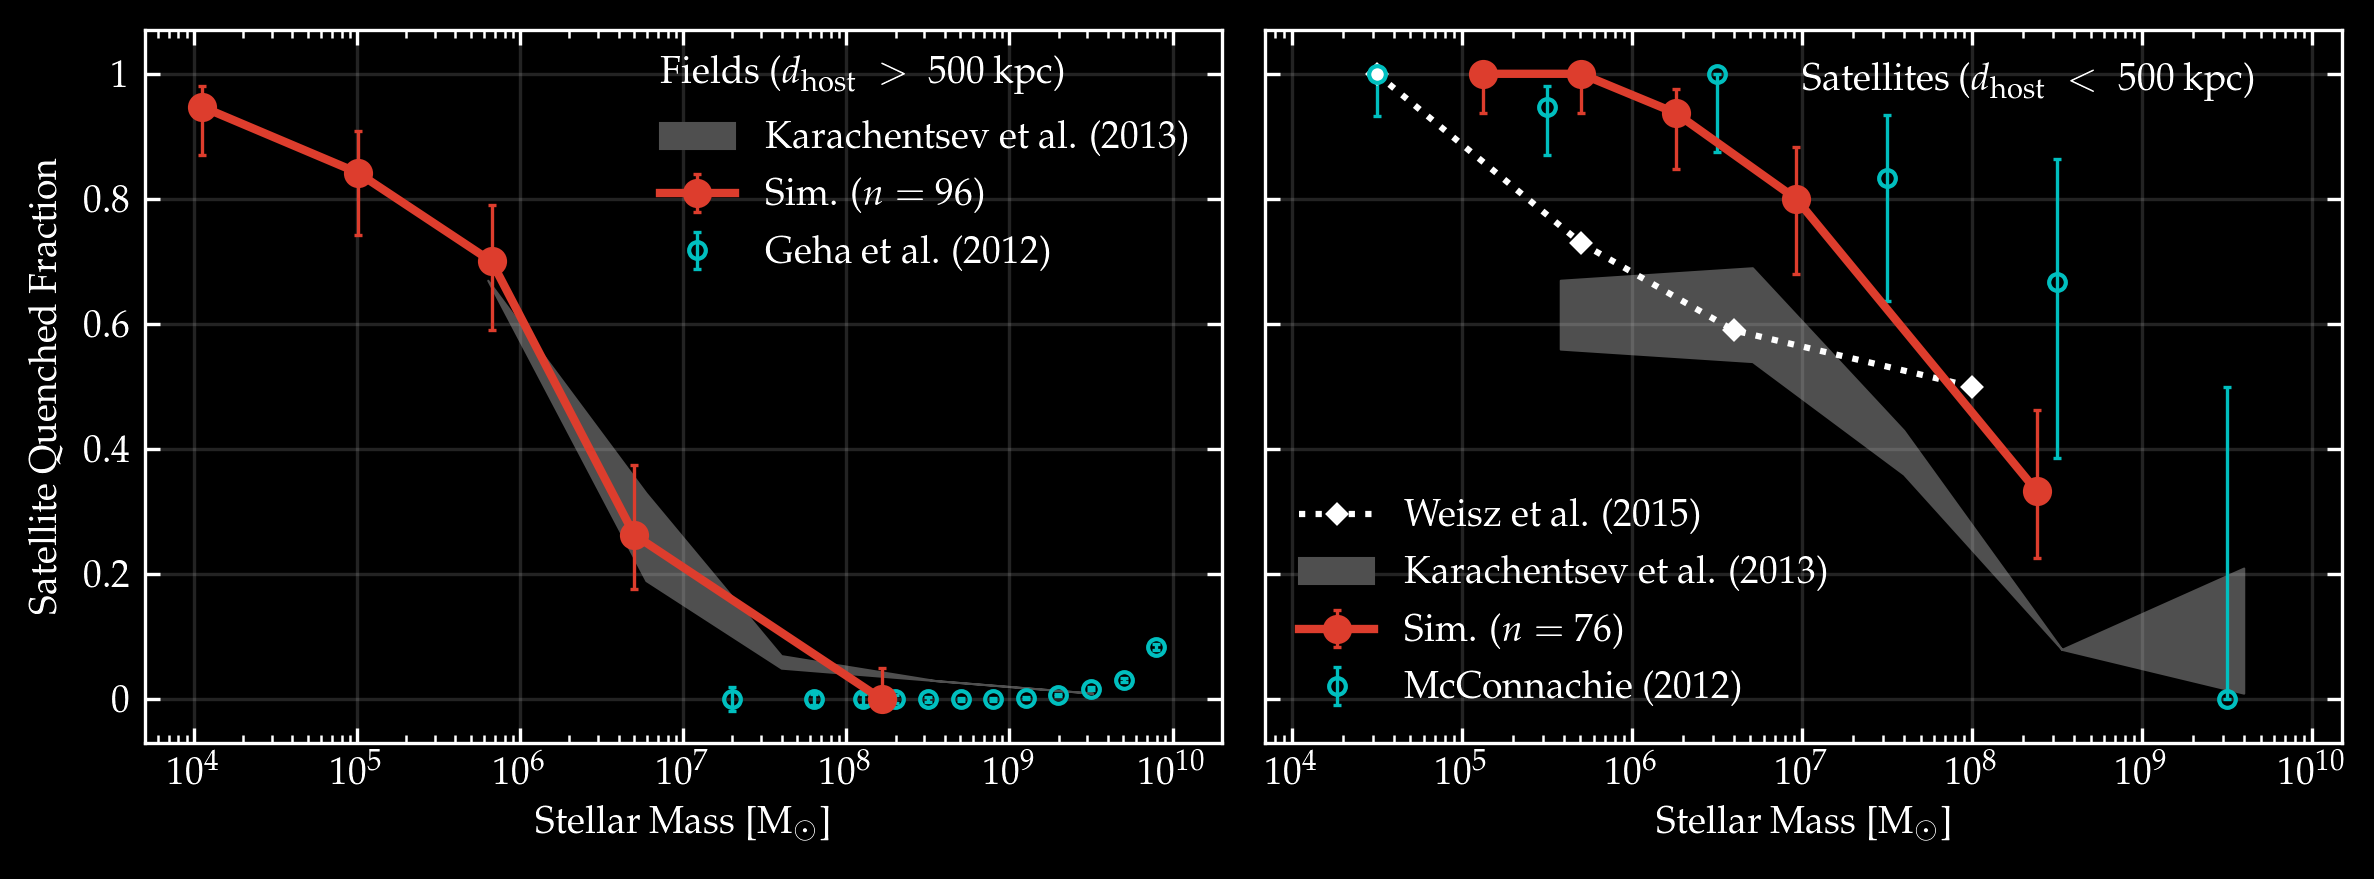

In [63]:
mpl.rcParams['text.color'] = 'w'

# load in the data and clean up 
data = read_all()
data = data[data['n_star']>10]



# load in distance to nearest host
dist, vir = distance_to_nearest_host(data)
s = dist < 500 # define satellites as those where dist < 500 kpc (to go on lower panel)
s = s[dist!=0]
mass = np.log10(np.array(data['M_star'],dtype=float))[dist!=0]
q = quenched(data)[dist!=0]
dist = dist[dist!=0]


# set up import plotting stuff
nbins = 5
colors = ['#DD3D2D', '#FDB366']
markers = ['D','o','^']
fig,ax = plt.subplots(1,2,figsize=(8,3),dpi=300,sharey=True)

# First, plot only field dwarfs (upper panel)
quantiles = np.linspace(0.0,1.0,nbins+1)
bin_edges = stats.mstats.mquantiles(mass[~s],quantiles)
y2, binEdges2 = np.histogram(mass[~s],bins=bin_edges)
y1, binEdges1 = np.histogram(mass[q & ~s], bins=bin_edges)
bincenters = 0.5*(binEdges1[1:]+binEdges1[:-1])
p = y1/y2
M = y2
ax[0].errorbar(10**bincenters,y1/y2,
               yerr = np.array([p - WilsonScoreInterval(-1, p, M), WilsonScoreInterval(1, p, M) - p]),
               fmt='o-',
               marker=markers[1],
               c=colors[0],
               label='Sim. ($n=\ $%s)' % len(mass[~s]),
               linewidth=2,
               zorder=20, 
               elinewidth=0.8, capsize=1,capthick=0.8)
   

print('field QF > 1e7',len(mass[~s&q&(mass>7)])/len(mass[~s&(mass>7)]))
print('field QF > 1e8',len(mass[~s&q&(mass>8)])/len(mass[~s&(mass>8)]))

# add Geha et al (2012) observational data (from table in paper)
bincenters = np.array([9.9,9.7,9.5,9.3,9.1,8.9,8.7,8.5,8.3,8.1,7.8,7.3])
y = np.array([0.084,0.031,0.017,0.007,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000])
yerr= np.array([0.0052,0.0032,0.0023,0.0016,0.0014,0.0019,0.0028,0.0043,0.0065,0.0091,0.0093,0.0193])

ax[0].errorbar(10**bincenters,y, yerr=yerr,marker='o',ms=4, linestyle='none', linewidth=2,ecolor='c',
               mec = 'c',mfc = 'none',elinewidth=0.8, capsize=1,capthick=0.8,clip_on=False,label='Geha et al. (2012)')


# add Karachentsev et al (2013) observational data compiled by Weisz (2014) (from table in paper)
bincenters = np.array([5.8,6.77,7.6,8.55,9.51])
y1 = np.array([0.67,0.19,0.05,0.03,0.01])
y2 = np.array([0.67,0.33,0.07,0.03,0.01])
ax[0].fill_between(10**bincenters, y1, y2, fc='#4f4f4f', ec='#4f4f4f', lw=0.5, label='Karachentsev et al. (2013)')


# add lines at 0 and 1    
ax[0].plot([1e3,1e12],[0,0],linestyle='-',color='k',linewidth=1,zorder=0,alpha=0.2)
ax[0].plot([1e3,1e12],[1,1],linestyle='-',color='k',linewidth=1,zorder=0,alpha=0.2)
    
# labels and limits
ax[0].set_ylim(-0.07,1)
ax[0].grid(alpha=0.2)

# legend and ticks
leg = ax[0].legend(prop={'size':9},frameon=False, loc = 'upper right', title=r'Fields ($d_{\mathrm{host}}\ >\ 500\ \mathrm{kpc}$)')
leg._legend_box.align = "left"
leg_texts = leg.get_texts() # list of matplotlib Text instances.
for i in range(len(leg_texts)):
    leg_texts[i].set_color('w')

ax[0].semilogx()
ax[0].tick_params(direction='in',which='both', colors='w')
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')
ax[0].set_yticklabels([None,0,0.2,0.4,0.6,0.8,1])
ax[0].set_xlim(5e3,2e10)


# Next, plot only satellites (bottom panel)
bin_edges = stats.mstats.mquantiles(mass[s],quantiles)
y2, binEdges2 = np.histogram(mass[s],bins=bin_edges)
y1, binEdges1 = np.histogram(mass[q & s], bins=bin_edges)
bincenters = 0.5*(binEdges1[1:]+binEdges1[:-1])

p = y1/y2
M = y2

ax[1].errorbar(10**bincenters,y1/y2,
               yerr = np.array([p - WilsonScoreInterval(-1, p, M), WilsonScoreInterval(1, p, M) - p]),
               fmt='o-',
               marker=markers[1],
               c=colors[0],
               label='Sim. ($n=\ $%s)' % len(mass[s]),
               linewidth=2,
               zorder=20, 
               elinewidth=0.8, capsize=1,capthick=0.8)


# add Karachentsev et al (2013) observational data compiled by Weisz (2015) (data from table)
bincenters = np.array([5.58,6.71,7.6,8.53,9.6])
y1 = np.array([0.56,0.54,0.36,0.08,0.21])
y2 = np.array([0.67,0.69,0.43,0.08,0.01])
ax[1].fill_between(10**bincenters, y1, y2, fc='#4f4f4f', ec='#4f4f4f', lw=0.5, label='Karachentsev et al. (2013)')

# add McConnachie (2012) data as seen in Wetzel (2015) observational data (data from previous cell)
yerr_lower = All_Mc - WilsonScoreInterval(-1,All_Mc,All_N_Mc)
yerr_upper = WilsonScoreInterval(1,All_Mc,All_N_Mc)-All_Mc
ax[1].errorbar(10**bc_Mc[1:],All_Mc[1:], 
               yerr=np.array([yerr_lower[1:], yerr_upper[1:]]),
               marker='o',ms=4, linestyle='none', linewidth=2,ecolor='c',mec = 'c',
               mfc = 'none',elinewidth=0.8, capsize=1,capthick=0.8,clip_on=False,label='McConnachie (2012)')

# add Weisz et al (2015) observational data (data from table)
bincenters = np.array([4.5,5.7,6.6,8.0])
y = np.array([1,0.73,0.59,0.5])
ax[1].plot(10**bincenters, y, 'D:', color='w', markersize=3, label='Weisz et al. (2015)')


ax[1].annotate(r'Satellites ($d_{\mathrm{host}}\ <\ 500\ \mathrm{kpc}$)', (1e7,0.96),  color='w')

ax[1].plot([1e3,1e12],[0,0],linestyle='-',color='k',linewidth=1,zorder=0,alpha=0.2)
ax[1].plot([1e3,1e12],[1,1],linestyle='-',color='k',linewidth=1,zorder=0,alpha=0.2)
    
# labels and limits
ax[1].set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax[1].set_ylim(-0.07,1.07)
ax[1].set_xlim(7e3,1.5e10)
ax[1].grid(alpha=0.2)

# legend and ticks
leg2 = ax[1].legend(prop={'size':9},frameon=False, loc='lower left')
leg2_texts = leg2.get_texts() # list of matplotlib Text instances.
for i in range(len(leg2_texts)):
    leg2_texts[i].set_color('w')

ax[1].semilogx()
ax[1].tick_params(direction='in',which='both', colors='w')
ax[1].yaxis.set_ticks_position('both')
ax[1].xaxis.set_ticks_position('both')
ax[1].set_yticklabels([None,0,0.2,0.4,0.6,0.8,1])
ax[0].set_ylabel('Satellite Quenched Fraction')
ax[0].set_xlabel('Stellar Mass [M$_{\odot}$]')


fig.patch.set_facecolor('black')
ax[0].set_facecolor('black')
ax[1].set_facecolor('black')


for i in [0,1]:
    ax[i].spines['bottom'].set_color('w')
    ax[i].spines['top'].set_color('w') 
    ax[i].spines['right'].set_color('w')
    ax[i].spines['left'].set_color('w')

    ax[i].yaxis.label.set_color('w')
    ax[i].xaxis.label.set_color('w')

    ax[i].title.set_color('w')


# save and show
plt.subplots_adjust(wspace=0.)
plt.tight_layout()
plt.savefig('Observational_Comparisons_Present.png',dpi=300, facecolor='k')
plt.show()
mpl.rcParams['text.color'] = 'k'

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


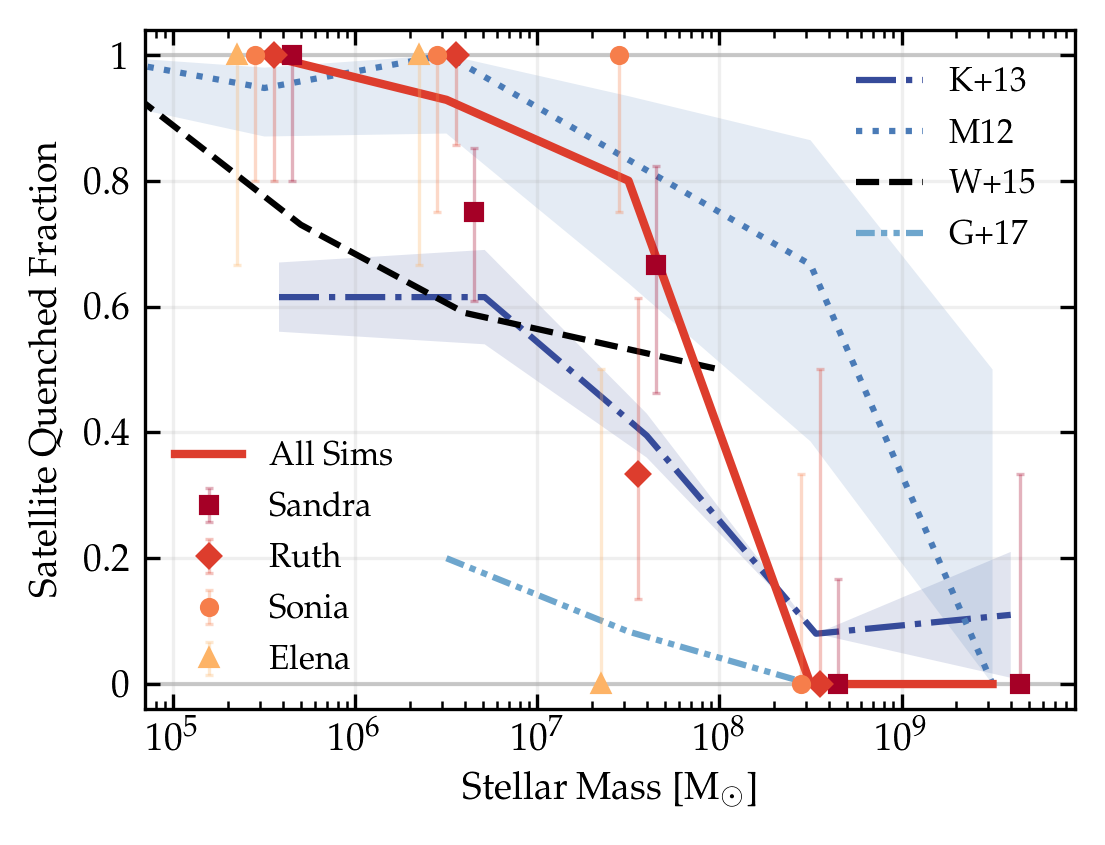

In [35]:
# load in the data and clean up 
data = read_sat()
data = data[data['n_star']>100]

# load in distance to nearest host
dist, vir = distance_to_nearest_host(data)
s = dist < 300 # define satellites as those where dist < 500 kpc (to go on lower panel)
s = s[dist!=0]
Mr = np.array(data.R_mag, dtype=float)[dist!=0]
Mr_sol = 4.65
L = 10**((Mr_sol - Mr)/2.5)
mass = np.log10(L)
q = quenched(data)[dist!=0]
dist = dist[dist!=0]


# set up import plotting stuff
nbins = 5
colors = ['#A50026','#DD3D2D', '#F67E4B', '#FDB366']
obs_colors = ['#364B9A', '#4A7BB7', '#6EA6CD', '#98CAE1'] 
offsets = np.array([-0.15,-0.05,0.05,0.15])


fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=300,sharex=True)


# First, plot all sims
bin_edges = np.arange(3,11)
y2, binEdges2 = np.histogram(mass[s],bins=bin_edges)
y1, binEdges1 = np.histogram(mass[q & s], bins=bin_edges)
bincenters = 0.5*(binEdges1[1:]+binEdges1[:-1])
p, = ax.plot(10**bincenters, y1/y2, '-', color='#DD3D2D', linewidth=2, zorder=20)
sim_plots = [p]
sim_labels = ['All Sims']



# add Karachentsev et al (2013) observational data compiled by Weisz (2015) (data from table)
bincenters = np.array([5.58,6.71,7.6,8.53,9.6])
y1 = np.array([0.56,0.54,0.36,0.08,0.21])
y2 = np.array([0.67,0.69,0.43,0.08,0.01])
ax.fill_between(10**bincenters, y1, y2, fc=obs_colors[0], ec='none', alpha=0.15, lw=0.5)
p, = ax.plot(10**bincenters, (y1+y2)/2, '-.', color=obs_colors[0], markersize=2.5, linewidth=1.5)
obs_plots = [p]
obs_labels = ['K+13']

# add McConnachie (2012) data as seen in Wetzel (2015) observational data (data from previous cell)
yerr_lower = All_Mc - WilsonScoreInterval(-1,All_Mc,All_N_Mc)
yerr_upper = WilsonScoreInterval(1,All_Mc,All_N_Mc)-All_Mc
p, = ax.plot(10**bc_Mc[1:], All_Mc[1:], ':', color=obs_colors[1], markersize=2.5, linewidth=1.5)
obs_plots.append(p)
obs_labels.append('M12')
ax.fill_between(10**bc_Mc[1:], All_Mc[1:] - yerr_lower[1:], All_Mc[1:] + yerr_upper[1:], 
               fc = obs_colors[1], ec='none', alpha=0.15, lw=0.5)


# add Weisz et al (2015) observational data (data from table)
bincenters = np.array([4.5,5.7,6.6,8.0])
y = np.array([1,0.73,0.59,0.5])
p, = ax.plot(10**bincenters, y, '--', color='k', markersize=2.5, linewidth=1.5)

obs_plots.append(p)
obs_labels.append('W+15')


# add Geha et al. (2017) data (SAGA)
SAGA = pd.read_csv('SAGA_data_cleaned.csv')

Mr_sol = 4.65
L = 10**((Mr_sol - np.array(SAGA.M_r))/2.5)
mass = np.log10(L)

bin_edges = np.arange(3,11)
y1, binEdges = np.histogram(mass, bin_edges)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
y2, binEdges = np.histogram(mass[SAGA.halpha=='N'], bins = binEdges)
y = y2/y1
p, = ax.plot(10**bincenters,y, linestyle=(0, (3, 1, 1, 1, 1, 1)), color=obs_colors[-2], linewidth=1.5)
SAGA_lower = WilsonScoreInterval(-1,y,y1)
SAGA_upper = WilsonScoreInterval(1,y,y1)
# ax.fill_between(10**bincenters, SAGA_lower, SAGA_upper, fc=obs_colors[-2], ec='none', alpha=0.15, lw=0.5)

obs_plots.append(p)
obs_labels.append('G+17')


for name,label,color,mark,off in zip(['h148','h229','h242','h329'],['Sandra','Ruth','Sonia','Elena'],colors,['s','D','o','^'],offsets):
    data = read_file(name)
    data = data[data['n_star']>100]

    # load in distance to nearest host
    dist, vir = distance_to_nearest_host(data)
    s = dist < 300 # define satellites as those where dist < 500 kpc \
    s = s[dist!=0]
    
    Mr = np.array(data.R_mag, dtype=float)[dist!=0]
    Mr_sol = 4.65
    L = 10**((Mr_sol - Mr)/2.5)
    mass = np.log10(L)    
    q = quenched(data)[dist!=0]
    dist = dist[dist!=0]

    bin_edges = np.arange(3,11)
    y2, binEdges2 = np.histogram(mass,bins=bin_edges)
    bincenters2 = 0.5*(binEdges2[1:]+binEdges2[:-1])
    y1, binEdges1 = np.histogram(mass[q],bins=bin_edges)
    bincenters = 0.5*(binEdges1[1:]+binEdges1[:-1])

    p = y1/y2
    M = y2

    markers, caps, bars = ax.errorbar(10**(bincenters-off),WilsonScoreInterval(0,p,M), 
                                      yerr=np.array([p - WilsonScoreInterval(-1,p,M), WilsonScoreInterval(1,p,M) - p]),
                                      color=color,
                                      marker=mark,
                                      ms=np.sqrt(13), 
                                      linestyle='none', 
                                      linewidth=2,
                                      ecolor=color,
                                      elinewidth=0.8, 
                                      capsize=1,
                                      capthick=0.8,
                                      clip_on=False,
                                      alpha = 1,
                                      zorder=105)
    
    # loop through bars and caps and set the alpha value
    [bar.set_alpha(0.3) for bar in bars]
    [cap.set_alpha(0.3) for cap in caps]
    
    sim_plots.append(mpl.container.ErrorbarContainer((markers, caps, bars), has_yerr=True))
    sim_labels.append(label)



ax.plot([1e3,1e12],[0,0],linestyle='-',color='k',linewidth=1,zorder=0,alpha=0.2)
ax.plot([1e3,1e12],[1,1],linestyle='-',color='k',linewidth=1,zorder=0,alpha=0.2)
    
# labels and limits
ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel('Satellite Quenched Fraction')
ax.set_ylim(-0.04,1.04)
ax.set_xlim(7e4,9e9)
ax.grid(alpha=0.2)

# legend and ticks
leg1 = ax.legend(sim_plots, sim_labels, prop={'size':8},frameon=False, loc='lower left')
leg2 = ax.legend(obs_plots, obs_labels, prop={'size':8},frameon=False, loc=(0.75,0.65))
ax.add_artist(leg1)

ax.semilogx()
ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.set_yticklabels([None,0,0.2,0.4,0.6,0.8,1])

# save and show
plt.savefig('plots/QF_F19.png',dpi=300)
plt.show()


## Quenched Fraction vs Stellar Mass

Intended to show variations across the simulations, but how that scatter averages out to something that matches observations. Particularly large scatter at $10^7 - 10^8$ $\mathrm{M}_{\odot}$.

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


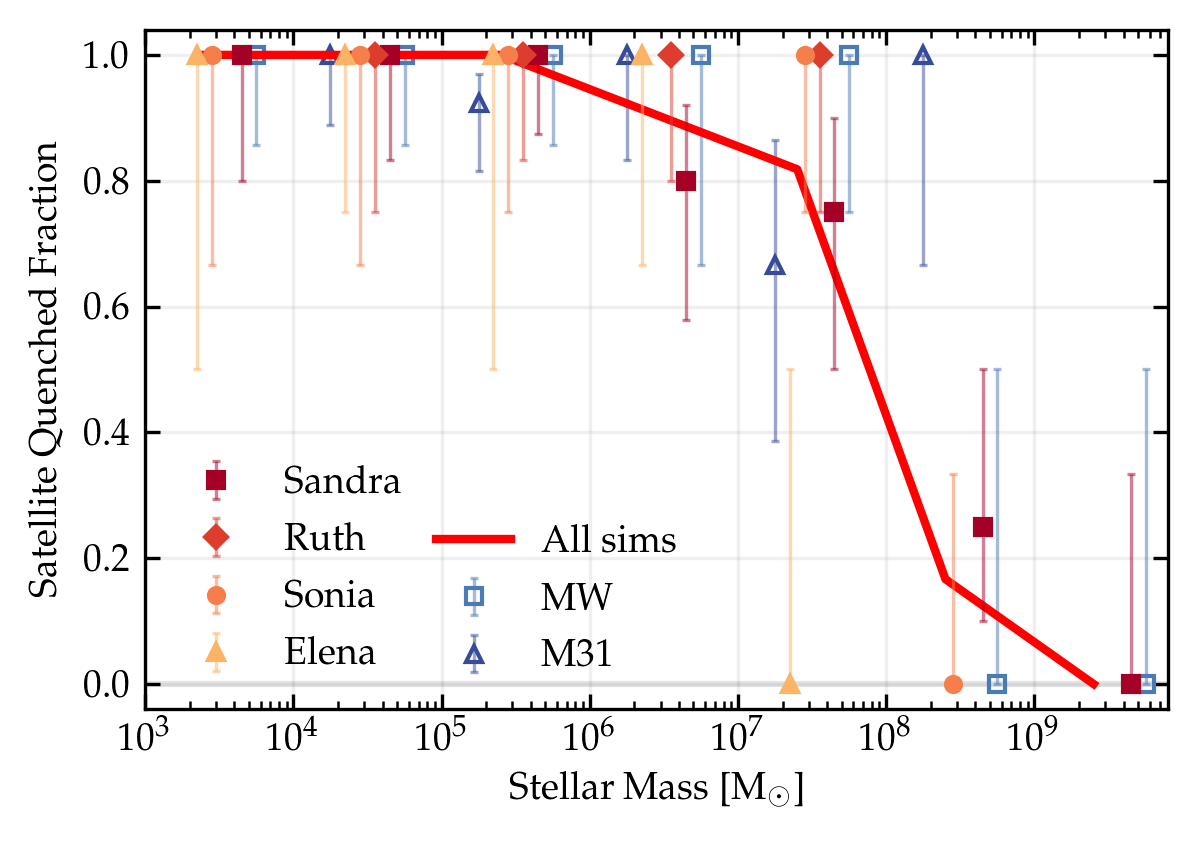

In [11]:
fig,ax = plt.subplots(1,1,figsize=(4.4,3),dpi=300)

data = read_sat()

mass = np.log10(np.array(data['M_star'][sat(data)],dtype=float))
q = quenched(data)[sat(data)]

bin_edges = np.arange(3,11)
y2, binEdges2 = np.histogram(mass,bins=bin_edges)
bincenters2 = 0.5*(binEdges2[1:]+binEdges2[:-1])
y1, binEdges1 = np.histogram(mass[q],bins=bin_edges)
bincenters = 0.5*(binEdges1[1:]+binEdges1[:-1])

obs_colors = ['#364B9A', '#4A7BB7', '#6EA6CD', '#98CAE1'] 
colors = ['#A50026','#DD3D2D', '#F67E4B', '#FDB366']


p1, = ax.plot(10**(bincenters-0.1),y1/y2, '-',
        color='r', 
        linewidth=2, 
        clip_on=False,zorder=101)

other_plots = [p1]
other_labels = ['All sims']
sim_plots = []
sim_labels = []

offsets = np.array([-0.15,-0.05,0.05,0.15])

for name,label,color,mark,off in zip(['h148','h229','h242','h329'],
                                     ['Sandra','Ruth','Sonia','Elena'],
                                     colors,['s','D','o','^'],offsets):
    data = read_file(name)
    
    mass = np.log10(np.array(data['M_star'][sat(data)],dtype=float))
    q = quenched(data)[sat(data)]
    prop = mass

    bin_edges = np.arange(3,11)
    y2, binEdges2 = np.histogram(prop,bins=bin_edges)
    bincenters2 = 0.5*(binEdges2[1:]+binEdges2[:-1])
    y1, binEdges1 = np.histogram(prop[q],bins=bin_edges)
    bincenters = 0.5*(binEdges1[1:]+binEdges1[:-1])

    p = y1/y2
    M = y2

    markers, caps, bars = ax.errorbar(10**(bincenters-off),WilsonScoreInterval(0,p,M), 
                                      yerr=np.array([p - WilsonScoreInterval(-1,p,M), WilsonScoreInterval(1,p,M) - p]),
                                      color=color,
                                      marker=mark,
                                      ms=np.sqrt(13), 
                                      linestyle='none', 
                                      linewidth=2,
                                      ecolor=color,
                                      elinewidth=0.8, 
                                      capsize=1,
                                      capthick=0.8,
                                      clip_on=False,
                                      alpha = 1,
                                      zorder=105)
    
    # loop through bars and caps and set the alpha value
    [bar.set_alpha(0.5) for bar in bars]
    [cap.set_alpha(0.5) for cap in caps]
    
    sim_plots.append(mpl.container.ErrorbarContainer((markers, caps, bars), has_yerr=True))
    sim_labels.append(label)
    

# add observational data
markers, caps, bars, = ax.errorbar(10**(bc_Mc+0.25), MW_Mc, yerr = np.array([MW_Mc-WilsonScoreInterval(-1,MW_Mc,MW_N_Mc), WilsonScoreInterval(1,MW_Mc,MW_N_Mc)-MW_Mc]),
                                   linestyle='none', elinewidth=0.8, capsize=1, capthick=0.8,
                                   marker='s', mec=obs_colors[1], mfc='none', ecolor=obs_colors[1], ms=np.sqrt(13), zorder=10, clip_on=False, label='MW')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

other_plots.append(mpl.container.ErrorbarContainer((markers, caps, bars), has_yerr=True))
other_labels.append('MW')

markers, caps, bars, = ax.errorbar(10**(bc_Mc-0.25), M31_Mc, yerr = np.array([M31_Mc-WilsonScoreInterval(-1,M31_Mc,M31_N_Mc), WilsonScoreInterval(1,M31_Mc,M31_N_Mc)-M31_Mc]),
                                   linestyle='none', elinewidth=0.8, capsize=1, capthick=0.8,
                                   marker='^', mec=obs_colors[0], mfc='none', ecolor=obs_colors[0], ms=np.sqrt(13), zorder=10, clip_on=False, label='M31')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

other_plots.append(mpl.container.ErrorbarContainer((markers, caps, bars), has_yerr=True))
other_labels.append('M31')

# zero line
ax.plot([1e2,1e11],[0,0],c='k',alpha=0.1,linestyle='-')
    
# labels and limits 
ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel('Satellite Quenched Fraction')
ax.set_xlim(1e3,8e9)
ax.set_ylim(-0.04,1.04)
ax.semilogx()

# ticks
ax.grid(alpha=0.2)
ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
 
# legend
leg1 = ax.legend(sim_plots, sim_labels, loc='lower left', frameon=False, prop={'size':9})
leg2 = ax.legend(other_plots, other_labels, loc=(0.27, 0.025), frameon=False, prop={'size':9})
ax.add_artist(leg1)


# save and show
# plt.savefig('Individual_Comparisons.png',dpi=300)
plt.show() 


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


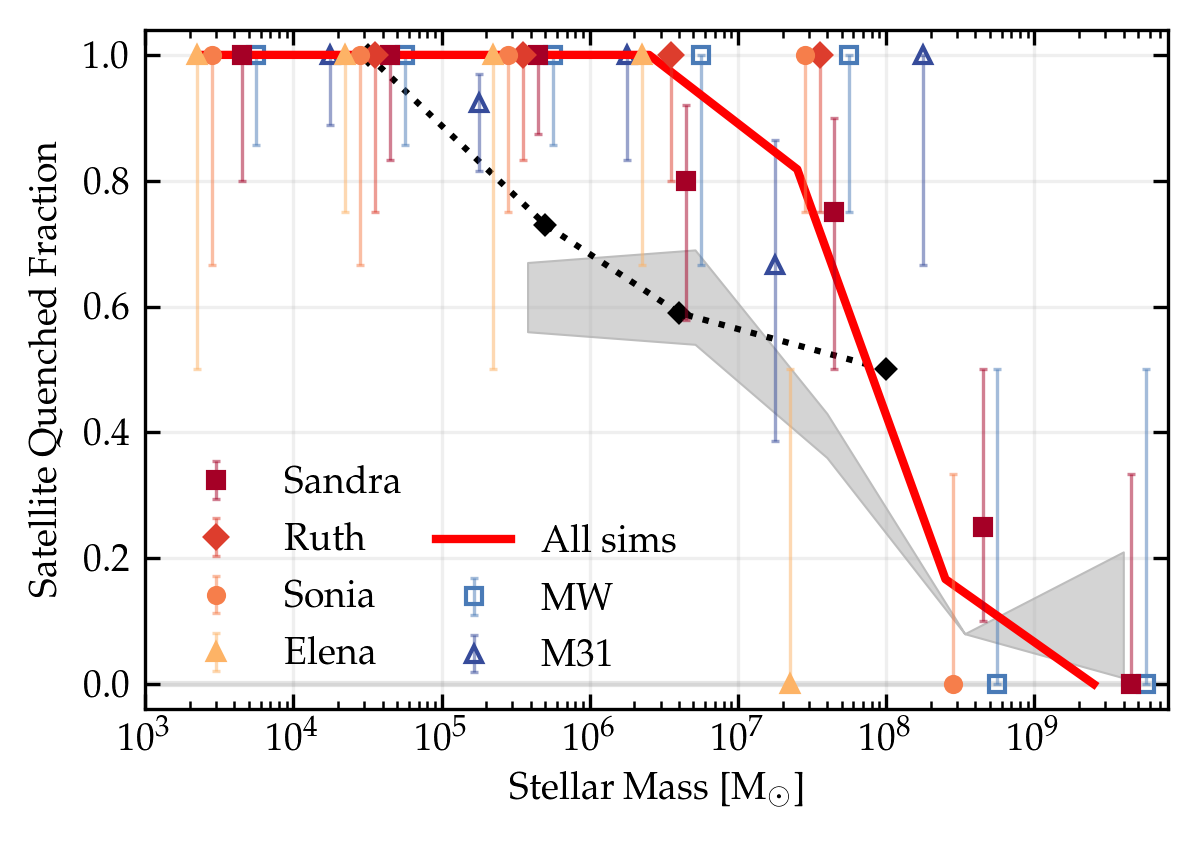

In [31]:
fig,ax = plt.subplots(1,1,figsize=(4.4,3),dpi=300)

data = read_sat()
data = data[whichHost(data)==1]

mass = np.log10(np.array(data.M_star,dtype=float))
q = quenched(data)

bin_edges = np.arange(3,11)
y2, binEdges2 = np.histogram(mass,bins=bin_edges)
bincenters2 = 0.5*(binEdges2[1:]+binEdges2[:-1])
y1, binEdges1 = np.histogram(mass[q],bins=bin_edges)
bincenters = 0.5*(binEdges1[1:]+binEdges1[:-1])

obs_colors = ['#364B9A', '#4A7BB7', '#6EA6CD', '#98CAE1'] 
colors = ['#A50026','#DD3D2D', '#F67E4B', '#FDB366']


p1, = ax.plot(10**(bincenters-0.1),y1/y2, '-',
        color='r', 
        linewidth=2, 
        clip_on=False,zorder=101)

other_plots = [p1]
other_labels = ['All sims']
sim_plots = []
sim_labels = []

offsets = np.array([-0.15,-0.05,0.05,0.15])

for name,label,color,mark,off in zip(['h148','h229','h242','h329'],
                                     ['Sandra','Ruth','Sonia','Elena'],
                                     colors,['s','D','o','^'],offsets):
    data = read_file(name)
    
    mass = np.log10(np.array(data['M_star'][sat(data)],dtype=float))
    q = quenched(data)[sat(data)]
    prop = mass

    bin_edges = np.arange(3,11)
    y2, binEdges2 = np.histogram(prop,bins=bin_edges)
    bincenters2 = 0.5*(binEdges2[1:]+binEdges2[:-1])
    y1, binEdges1 = np.histogram(prop[q],bins=bin_edges)
    bincenters = 0.5*(binEdges1[1:]+binEdges1[:-1])

    p = y1/y2
    M = y2

    markers, caps, bars = ax.errorbar(10**(bincenters-off),WilsonScoreInterval(0,p,M), 
                                      yerr=np.array([p - WilsonScoreInterval(-1,p,M), WilsonScoreInterval(1,p,M) - p]),
                                      color=color,
                                      marker=mark,
                                      ms=np.sqrt(13), 
                                      linestyle='none', 
                                      linewidth=2,
                                      ecolor=color,
                                      elinewidth=0.8, 
                                      capsize=1,
                                      capthick=0.8,
                                      clip_on=False,
                                      alpha = 1,
                                      zorder=105)
    
    # loop through bars and caps and set the alpha value
    [bar.set_alpha(0.5) for bar in bars]
    [cap.set_alpha(0.5) for cap in caps]
    
    sim_plots.append(mpl.container.ErrorbarContainer((markers, caps, bars), has_yerr=True))
    sim_labels.append(label)
    

# add observational data
markers, caps, bars, = ax.errorbar(10**(bc_Mc+0.25), MW_Mc, yerr = np.array([MW_Mc-WilsonScoreInterval(-1,MW_Mc,MW_N_Mc), WilsonScoreInterval(1,MW_Mc,MW_N_Mc)-MW_Mc]),
                                   linestyle='none', elinewidth=0.8, capsize=1, capthick=0.8,
                                   marker='s', mec=obs_colors[1], mfc='none', ecolor=obs_colors[1], ms=np.sqrt(13), zorder=10, clip_on=False, label='MW')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

other_plots.append(mpl.container.ErrorbarContainer((markers, caps, bars), has_yerr=True))
other_labels.append('MW')

markers, caps, bars, = ax.errorbar(10**(bc_Mc-0.25), M31_Mc, yerr = np.array([M31_Mc-WilsonScoreInterval(-1,M31_Mc,M31_N_Mc), WilsonScoreInterval(1,M31_Mc,M31_N_Mc)-M31_Mc]),
                                   linestyle='none', elinewidth=0.8, capsize=1, capthick=0.8,
                                   marker='^', mec=obs_colors[0], mfc='none', ecolor=obs_colors[0], ms=np.sqrt(13), zorder=10, clip_on=False, label='M31')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

other_plots.append(mpl.container.ErrorbarContainer((markers, caps, bars), has_yerr=True))
other_labels.append('M31')



# add Karachentsev et al (2013) observational data compiled by Weisz (2015) (data from table)
bincenters = np.array([5.58,6.71,7.6,8.53,9.6])
y1 = np.array([0.56,0.54,0.36,0.08,0.21])
y2 = np.array([0.67,0.69,0.43,0.08,0.01])
ax.fill_between(10**bincenters, y1, y2, fc='#d4d4d4', ec='#bdbdbd', lw=0.5, label='Karachentsev et al. (2013)')

# add Weisz et al (2015) observational data (data from table)
bincenters = np.array([4.5,5.7,6.6,8.0])
y = np.array([1,0.73,0.59,0.5])
ax.plot(10**bincenters, y, 'D:', color='k', markersize=3, label='Weisz et al. (2015)')




# zero line
ax.plot([1e2,1e11],[0,0],c='k',alpha=0.1,linestyle='-')
    
# labels and limits 
ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel('Satellite Quenched Fraction')
ax.set_xlim(1e3,8e9)
ax.set_ylim(-0.04,1.04)
ax.semilogx()

# ticks
ax.grid(alpha=0.2)
ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
 
# legend
leg1 = ax.legend(sim_plots, sim_labels, loc='lower left', frameon=False, prop={'size':9})
leg2 = ax.legend(other_plots, other_labels, loc=(0.27, 0.025), frameon=False, prop={'size':9})
ax.add_artist(leg1)


# save and show
plt.show() 


# Why does quenching extend so far beyond 300 kpc? 

Here I plot the distance to nearest host $d_{\mathrm{host}}$ vs the distance to nearest *halo* (with no mass threshold). Blue points are the least massive halos and green points are intermediate mass. Notice that all the solid, blue points are both far from the nearest central galaxy and far from the nearest galaxy (upper right corner of the plot). 

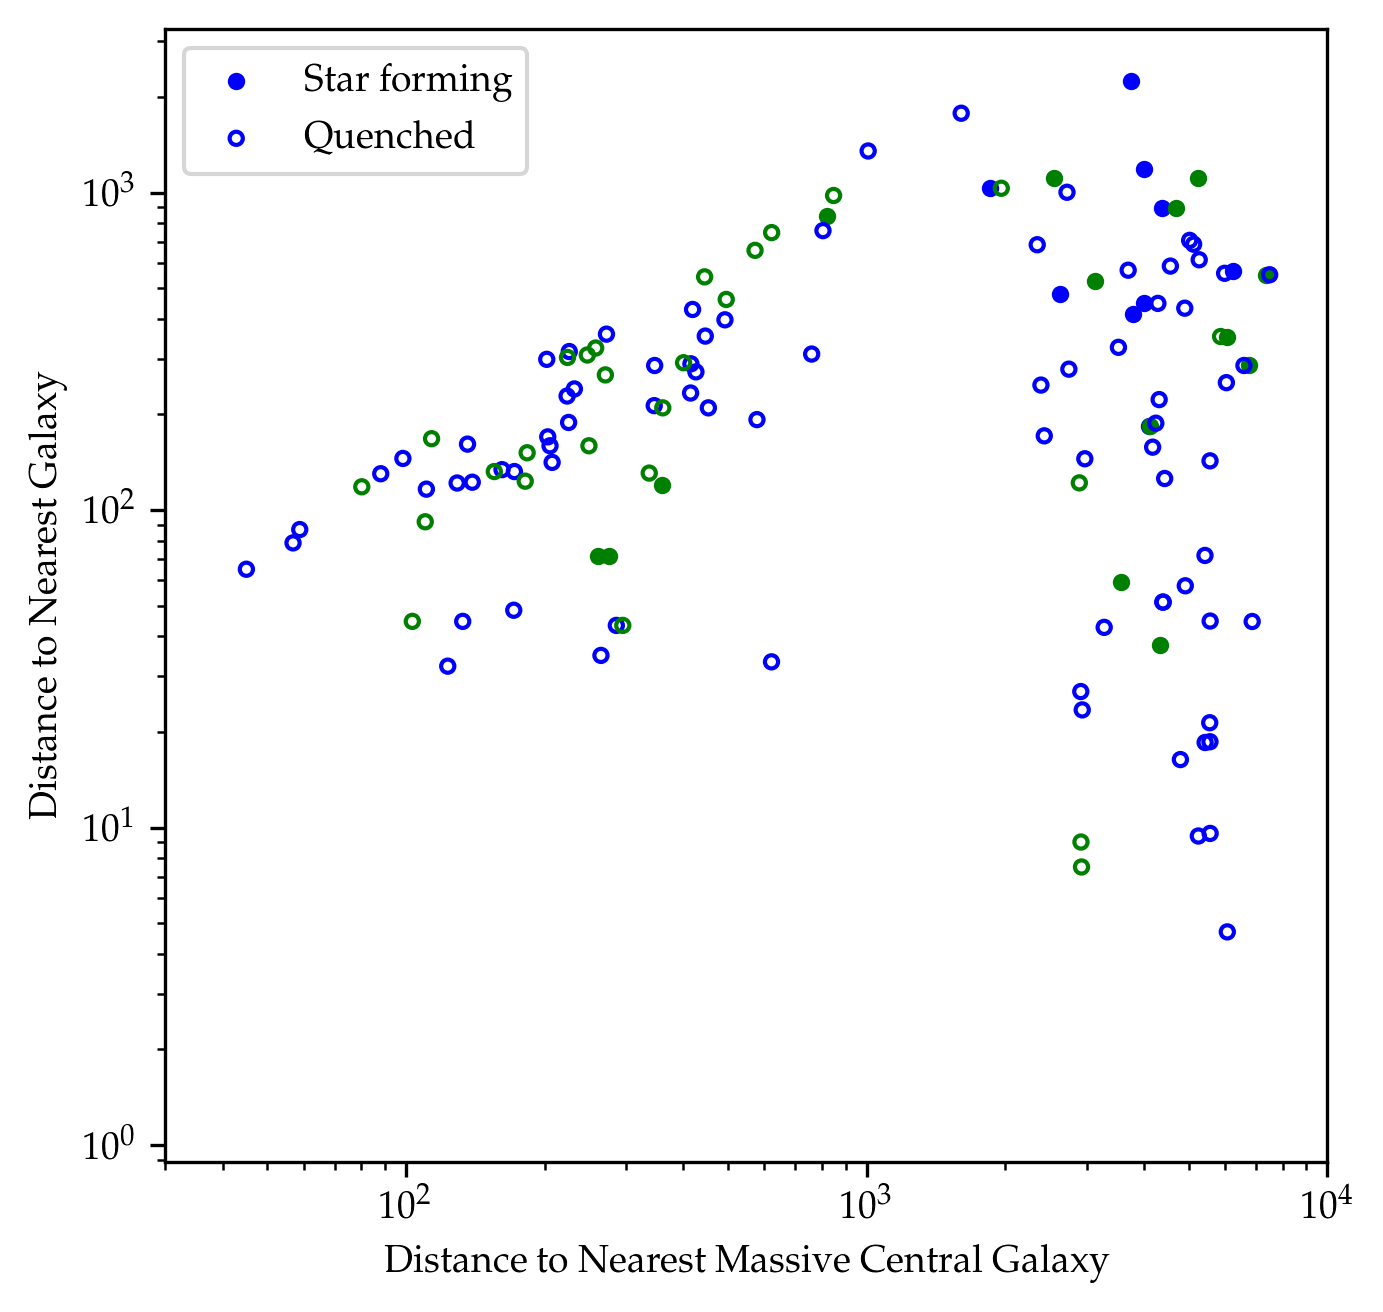

In [9]:
data = read_all()
data = data[data.n_star > 10]

dist_massive,virs = distance_to_nearest_host(data)
dist_nearest = distance_to_nearest_halo(data)
mstar = np.log10(np.array(data.M_star, dtype=float))

fig, ax = plt.subplots(1,1,figsize=(5,5),dpi=300)

dist_massive_u = dist_massive[~quenched(data)]
dist_nearest_u = dist_nearest[~quenched(data)]
mstar_u = mstar[~quenched(data)]
dist_massive_q = dist_massive[quenched(data)]
dist_nearest_q = dist_nearest[quenched(data)]
mstar_q = mstar[quenched(data)]

size = 10

ax.scatter(dist_massive_u[(mstar_u < 6.1)],dist_nearest_u[(mstar_u < 6.1)], c='b',s=size, label='Star forming')
ax.scatter(dist_massive_u[(mstar_u > 6.1)&(mstar_u < 7.1)], dist_nearest_u[(mstar_u > 6.1)&(mstar_u < 7.1)], c='g',s=size)
# ax.scatter(dist_massive_u[(mstar_u > 7.1)],dist_nearest_u[(mstar_u > 7.1)], c='c',s=size)


ax.scatter(dist_massive_q[(mstar_q < 6.1)],dist_nearest_q[(mstar_q < 6.1)], edgecolor='b', facecolor='none',s=size, label='Quenched')
ax.scatter(dist_massive_q[(mstar_q > 6.1)&(mstar_q < 7.1)], dist_nearest_q[(mstar_q > 6.1)&(mstar_q < 7.1)], edgecolor='g',facecolor='none',s=size)
# ax.scatter(dist_massive_q[(mstar_q > 7.1)],dist_nearest_q[(mstar_q > 7.1)], edgecolor='c',facecolor='none',s=size)


ax.loglog()
ax.set_xlim(30,1e4)
ax.set_xlabel('Distance to Nearest Massive Central Galaxy')
ax.set_ylabel('Distance to Nearest Galaxy')
ax.legend()
plt.show()